## 1 Data reprocessing

有个说法叫4c , ```correcting`,`creating`,`converting`
实际中可将train,test合并处理，处理完毕后再分开.

主要处理这2类数据:

### Outlier
原作者用的Tukey检验.

按ng的书　应该也可以用高斯检验，或者sklearn里提出的其他的检验方法.

[参考](http://sklearn.apachecn.org/cn/stable/auto_examples/covariance/plot_outlier_detection.html#sphx-glr-auto-examples-covariance-plot-outlier-detection-py)

### Missing Data
null填补.　

数值型：

用满足置信区间的随机均值;

用其他特征来预测;(容易overfit)

离散型:

用随机离散值;

较少的空缺的话，用均值，分布最大离散特征之类的都可以。

### one-hot encode

针对的是**离散型特征**

one-hot 将特征按`寄存器比特状态一样`去处理，如[0 1 0] [1 0 0] [0 0 1]代表三个不同特征值，特征间彼此距离相等.

one-hot可以处理非连续性特征，但是增加了特征维度，而且更稀疏了，并不适合树型
[参考1](https://www.zhihu.com/question/266195966)

可以放在最后，一般和特征工程结合。对基于树的算法，one-hot可能效果不明显，而且带来了计算量，甚至可能引起overfit.

对于数值型算法，如回归算法，SVM.LR,GBDT等,一定是要one-hot的

如果用ensemable等算法，可以考虑全部one-hot掉

[get_dummies用法](https://blog.csdn.net/lujiandong1/article/details/52836051)

## Result Analysis

最新的voting已经有83%了，学习曲线看也比较完美.提交后....还是没单个的RF好(79%)

新加了xgboost，看上去完美(86%)，最终得分77.9% ....


看样子还是overfit的厉害。

若按照`6:2:2`的原则来做cv的话，应该从train里划出一个test来评估模型，而不是直接用最终的test_valid，可能会好点?

改变的原则是X_train为原来X_train的80%,剩下的20%为X_test用来做模型评估.根据评估值再来用cv集gridSearchCv调整模型.

很重要的原则是确保X_test和最终的预测集是`同分布`的，这样能保证X_test的值能准确评估模型.

In [4]:
#import libs
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import seaborn as sns;
%matplotlib inline

from collections import Counter;
# RF, Adaboost,GBDT, Extratree, Voting.
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier;
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis;
#LR
from sklearn.linear_model import LogisticRegression;
#KNN
from sklearn.neighbors import KNeighborsClassifier;
#DT
from sklearn.tree import DecisionTreeClassifier;
#full nn?
from sklearn.neural_network import MLPClassifier
#svm
from sklearn.svm import SVC
# K折线 学习曲线 
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve,KFold,cross_val_predict;
sns.set(style='white', context='notebook', palette='deep');

# conda install py-xgboost
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)


In [5]:
#load data
train = pd.read_csv("../../data/titanic/train.csv")
test = pd.read_csv("../../data/titanic/test.csv")
train.head(3)
train_len = len(train);
test_len = len(test);
IDtest = test["PassengerId"];

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
#outlier 
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
# 只有数值的特征才能算一些数值特征. id不算,因此只有pclass, age,Sibsp,Parch ,Fare了
Outliers_to_drop = detect_outliers(train,2,['Age','SibSp','Parch','Fare'])

train.loc[Outliers_to_drop]# Show the outliers rows



/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [9]:
# Drop outliers
# Not drop...any way
# train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True);

In [10]:
#train and test放在一起处理，方便
train_len = len(train)
test_len =  len(test)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [11]:
#样本总数，原始特征数
print(train_len)
print(test_len)
dataset.shape

891
418


(1309, 12)

In [12]:
#null情况
dataset.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

#### Embarked

['S' 'C' 'Q' nan]
miss Embarked (array([ 61, 829]),)


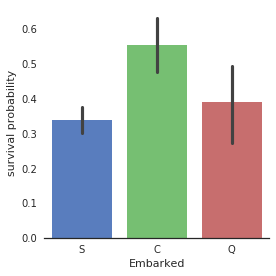

In [13]:
# 先看Embarked
print(dataset['Embarked'].unique())
out=np.where(dataset['Embarked'].isnull().values==True);
print('miss Embarked',out)
dataset.loc[out]
# 看下分布?
# Explore SibSp feature vs Survived
g = sns.factorplot(x="Embarked",y="Survived",data=train,kind="bar" , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [14]:
# 只有２个miss,选个中间的
dataset['Embarked'] = dataset['Embarked'].fillna("Q")

#### Fare

本身是数值型

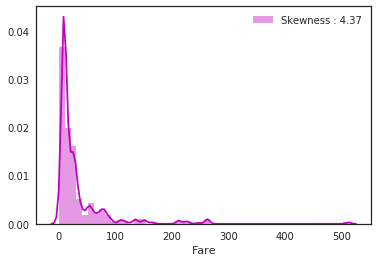

In [15]:
#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

# Explore Fare distribution 
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

In [16]:
# Apply log to Fare to reduce skewness distribution
#FAIR log处理，防止倾偏
# dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
# g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
# g = g.legend(loc="best")

# qcut一下
c = 4;
if len(dataset['Fare'].unique()) != c:
    dataset['Fare'] = pd.qcut(dataset['Fare'],c,labels=['low','mid','good','high'])


#### Age

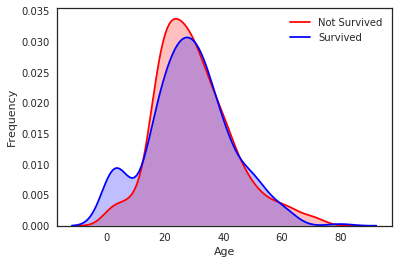

In [17]:
out=np.where(dataset['Age'].isnull().values==True);
# tuple转换成list  t第１个元素是np.array
#out =list(out[0]);

#用均值一个标准差内的随机均值填充
age_mean = dataset['Age'].mean();
std= dataset['Age'].std();
random_age_list = np.random.randint(age_mean - std , age_mean+std,len(out[0]));
dataset.loc[dataset['Age'].isnull(),'Age']=random_age_list;
# Explore Age distibution 
g = sns.kdeplot(dataset["Age"][(dataset["Survived"] == 0) & (dataset["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(dataset["Age"][(dataset["Survived"] == 1) & (dataset["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

dataset['Age']=pd.cut(dataset['Age'],5,labels=['child','teen','mid','old','older']);


#### Name

Name本身包含了身份信息，提取为Title

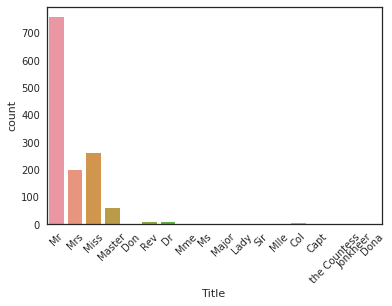

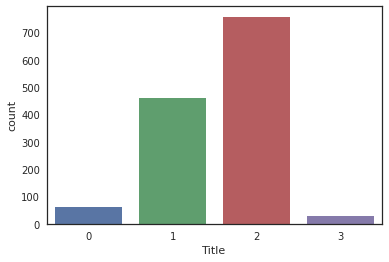

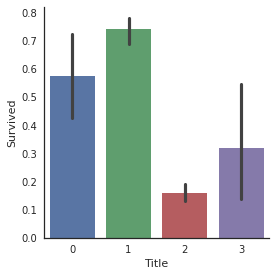

In [18]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)

### 看名字的情况，取titie的大类
#看名称的分布
g=sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

#将其他映射到'Rare',并且数值化
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3,'Sir':2 })
type(dataset['Title'])

plt.figure()
g =sns.countplot(x="Title",data=dataset)
g = sns.factorplot(x="Title", y = "Survived",data = dataset, kind="bar");

#### Parch Sibsp
Fsize = Parch + Sibsp +1

is_Alone  = (Fsize==1)?1:0

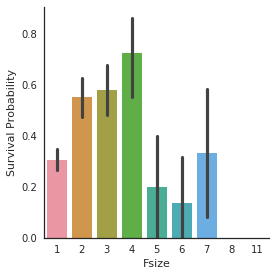

In [19]:
# familysize 合并parch and sibsp
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1
g = sns.factorplot(x="Fsize",y="Survived",data = dataset,kind='bar')
g = g.set_ylabels("Survival Probability")

#IsAlone
# dataset['IsAlone'] = dataset['Fsize'].apply(lambda x: x==1)
# g = sns.factorplot(x="IsAlone",y="Survived",data = dataset,kind='bar')
# g = g.set_ylabels("Survival Probability")

In [20]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

#### Cabin

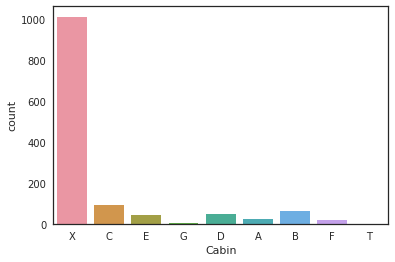

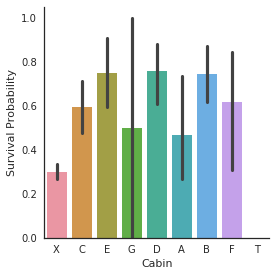

In [21]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

g = sns.countplot(x='Cabin',data=dataset)
g = sns.factorplot(x="Cabin",y="Survived",data = dataset,kind='bar')
g = g.set_ylabels("Survival Probability")


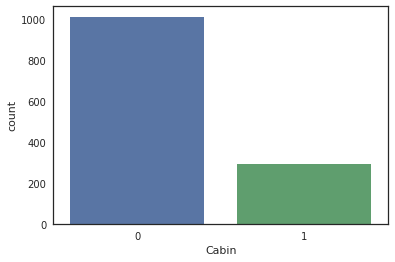

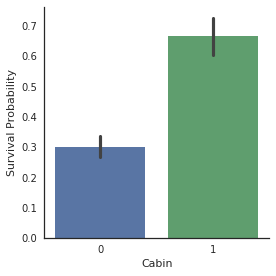

In [22]:

#X未知的但是很多　看下各自的生存状况　X很大a,但是大部分没有活下来
# 如果当成一个特征分量，感觉会overfit  
dataset.loc[dataset['Cabin'].isnull(),'Cabin',]='X';
# T太少　没必要单独做特征
dataset.loc[dataset['Cabin']=='T','Cabin',]='F';

# 采取随机赋值的策略
# L = ['A','B','C','D','E','F'];
# X_len = dataset[dataset['Cabin']=='X'].shape[0];
# random_list=np.random.random_integers(1,X_len,X_len)
# # print(random_list)
# res = [L[ x % len(L)] for x in random_list];
# dataset.loc[dataset['Cabin']=='X','Cabin',]=[L[ x % len(L)] for x in random_list];

dataset['Cabin'] = dataset['Cabin'].map({'X':0 ,'A':1,'B':1,'C':1,'D':1,'E':1,'F':1,'G':1})

#A B C D E F G T X
g = sns.countplot(x='Cabin',data=dataset)
g = sns.factorplot(x="Cabin",y="Survived",data = dataset,kind='bar')
g = g.set_ylabels("Survival Probability")


#### Ticket
直接删掉好了　认为没用

In [23]:
dataset.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Fsize,Single,SmallF,MedF,LargeF
0,teen,0,S,low,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2,2,0,1,0,0
1,mid,1,C,high,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,1,2,0,1,0,0
2,teen,0,S,mid,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,1,1,0,0,0
3,mid,1,S,high,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,1,2,0,1,0,0
4,mid,0,S,mid,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,2,1,1,0,0,0


Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Title', 'Fsize',
       'Single', 'SmallF', 'MedF', 'LargeF'],
      dtype='object')


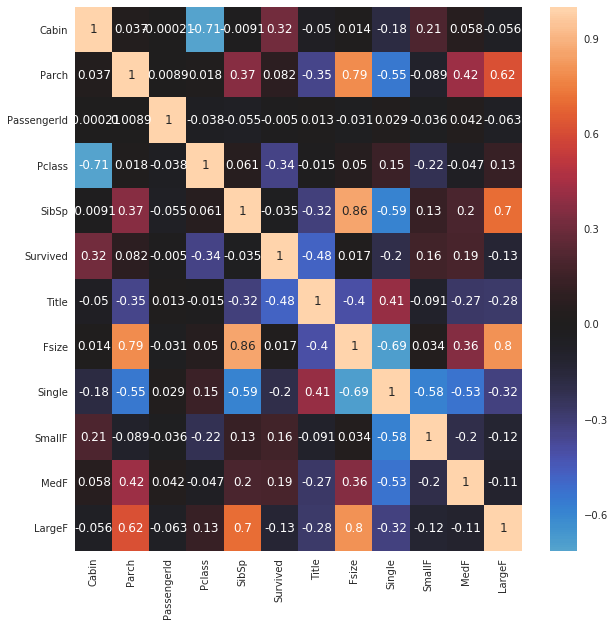

In [24]:
features = dataset.columns;
print(features)
fig, ax = plt.subplots(figsize=(10,10))
g= sns.heatmap(dataset.corr(), annot=True,ax=ax,center=0)

### Featue selection

In [25]:
# drop Name Ticket PassengerId
features=[
#           'Age',
#           'Cabin', 
#           'Embarked',
#           'Fare',
          'Name', 
#           'Parch',
          'PassengerId',
#        'Pclass', 
#           'Sex',
#            'SibSp',
#           'Survived',
          'Ticket', 
#           'Title',
          'Fsize',
#        'Single', 
#           'SmallF', 
#           'MedF',
#           'LargeF'
         ];

for f in features:
    if f in dataset.columns:
        dataset.drop(labels=[f],axis = 1, inplace = True);

    

# if 'Name' in dataset.columns:
#     dataset.drop(labels=['Name'],axis = 1, inplace = True);

# if 'PassengerId' in dataset.columns:
#     dataset.drop(labels=['PassengerId'],axis = 1, inplace = True);

# if 'Parch' in dataset.columns:
#     dataset.drop(labels=['Parch'],axis = 1, inplace = True);
        
# if 'SibSp' in dataset.columns:
#     dataset.drop(labels=['SibSp'],axis = 1, inplace = True);
    
# if 'Fsize' in dataset.columns:
#     dataset.drop(labels=['Fsize'],axis = 1, inplace = True);
    
# if 'Cabin' in dataset.columns:
#     dataset.drop(labels=['Cabin'],axis = 1, inplace = True);

In [26]:
## onehot部分离散特征
# dataset = pd.get_dummies(dataset, columns = ["Cabin"], prefix="Cab");
features=[
            'Age',
          'Cabin', 
          'Embarked',
          'Fare',
#           'Name', 
          'Parch',
#           'PassengerId',
       'Pclass', 
          'Sex',
#           'SibSp',
#           'Survived',
#           'Ticket', 
          'Title',
#           'Fsize',
#        'Single', 
#           'SmallF', 
#           'MedF',
#           'LargeF'
         ];
dataset = pd.get_dummies(dataset, columns = features);

# dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em");
# dataset = pd.get_dummies(dataset, columns = ["Fare"], prefix="F");
# # dataset = pd.get_dummies(dataset, columns = ["Parch"], prefix="Par");
# dataset = pd.get_dummies(dataset, columns = ["Pclass"], prefix="Pcl");
# dataset = pd.get_dummies(dataset, columns = ["Sex"], prefix="Se");
# # dataset = pd.get_dummies(dataset, columns = ["SibSp"], prefix="Sib");
# dataset = pd.get_dummies(dataset, columns = ["Title"], prefix="T");
# # dataset = pd.get_dummies(dataset, columns = ["Fsize"], prefix="Fsize");
# # dataset = pd.get_dummies(dataset, columns = ["IsAlone"], prefix="Alo");
# dataset = pd.get_dummies(dataset, columns = ["Age"], prefix="Ag");





# dataset['Fare'] = dataset['Fare'].astype(int)
# dataset['Age'] = dataset['Age'].astype(int)

#标准化
# mean = dataset['Age'].mean();
# std= dataset['Age'].std();
# dataset['Age'] = dataset['Age'].apply(lambda x: (x-mean)/std);

#Fsize
# mean = dataset['Fsize'].mean();
# std= dataset['Fsize'].std();
# dataset['Fsize'] = dataset['Fsize'].apply(lambda x: (x-mean)/std;

# mean = dataset['Fare'].mean();
# std= dataset['Fare'].std();
# dataset['Fare'] = dataset['Fare'].apply(lambda x: (x-mean)/std);



In [27]:
# 50特征
print(dataset.shape)
dataset.columns

(1309, 37)


Index(['SibSp', 'Survived', 'Single', 'SmallF', 'MedF', 'LargeF', 'Age_child',
       'Age_teen', 'Age_mid', 'Age_old', 'Age_older', 'Cabin_0', 'Cabin_1',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Fare_low', 'Fare_mid',
       'Fare_good', 'Fare_high', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3',
       'Parch_4', 'Parch_5', 'Parch_6', 'Parch_9', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Title_0', 'Title_1', 'Title_2',
       'Title_3'],
      dtype='object')

#### 1.5 reorder train and test

In [28]:
# train and test again 
dataset.head()

print('train_len:',train_len);
print('test_len:',test_len);

train_valid=dataset.loc[:train_len-1];
test_valid =dataset.loc[train_len:];

print('reoder train_len:',len(train_valid));
print('reorder test_len:',len(test_valid));

#print(dataset.loc[dataset['Survived'].isnull(),'Survived'])
# # # ## Separate train features and label 

train["Survived"] = train_valid["Survived"].astype(int)
Y_train = train_valid["Survived"]
X_train = train_valid.drop(labels = ["Survived"],axis = 1)

test_valid = test_valid.drop(labels=['Survived'],axis=1);

X_train.head()

train_len: 891
test_len: 418
reoder train_len: 891
reorder test_len: 418


,SibSp,Single,SmallF,MedF,LargeF,Age_child,Age_teen,Age_mid,Age_old,Age_older,...,Parch_9,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Title_0,Title_1,Title_2,Title_3
0,1,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0
1,1,0,1,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
2,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,1,0,0
3,1,0,1,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,1,0


In [29]:
# 对X_train Y_train做split, train/test 用test来评估模型，而不是用最终的submission_test
from sklearn.model_selection import train_test_split;

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)
print(X_train.shape)
print(X_test.shape)

(712, 36)
(179, 36)


### Modeling
SVC
Decision Tree
AdaBoost
Random Forest
Extra Trees
Gradient Boosting
Multiple layer perceprton (neural network)
KNN
Logistic regression
Linear Discriminant Analysis

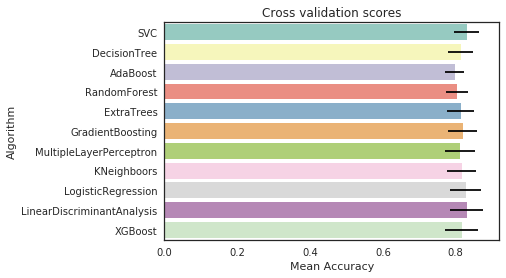

In [30]:
##模型训练

#kfold 
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10,shuffle=True);

# 分类器来吧
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(XGBClassifier())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis","XGBoost"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")



In [31]:
cv_means

[0.83005421417393244,
 0.81323049407556458,
 0.79785211267605638,
 0.80325005589090104,
 0.81322714062150681,
 0.81862508383635146,
 0.81197742007601159,
 0.81590934495864076,
 0.8272345182204337,
 0.82989716074223119,
 0.81588922423429477]

### 超参数调优

模型和数据决定了最终效果的上限，
就单个模型而言，用`GridSearchCV`来寻找最好的参数，去逼近上限

'ensemable'使用多个模型，接近理想值。


### 学习曲线
用学习曲线查看是否under fit /over fit的情况

In [32]:
# learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
# g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
# g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
# g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
# g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)
# g = plot_learning_curve(gsLR.best_estimator_,"LR learning curves",X_train,Y_train,cv=kfold)
#g = plot_learning_curve(gsXGB.best_estimator_,"XGboost learning curves",X_train,Y_train,cv=kfold)

#### XBGOOST

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  7.3min


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.02, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
0.832865168539


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  8.4min finished


test score: 0.821229050279


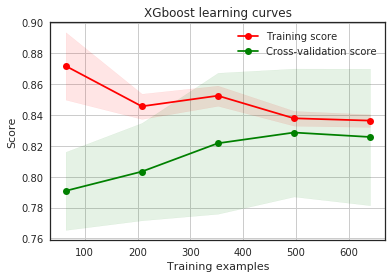

In [33]:
# Xgboost
XGBC = XGBClassifier()
## Search grid for optimal parameters
rf_param_grid = {
              "gamma": [0.02,0.05,0.1,1],
                "subsample":[0.6,0.8,1],
                 "colsample_bytree":[0.8,1],
                "n_estimators":[100,200],
                "learning_rate":[0.1,0.05,0.01],
                "subsample":[1,0.5,0.2]
                }

gsXGB = GridSearchCV(XGBC,param_grid = rf_param_grid, cv=kfold,n_jobs= -1, verbose = 1)

gsXGB.fit(X_train,Y_train)

XGB_best = gsXGB.best_estimator_
                 
print(XGB_best)
# Best score
print(gsXGB.best_score_)

g = plot_learning_curve(gsXGB.best_estimator_,"XGboost learning curves",X_train,Y_train,cv=kfold)

print('test score:',XGB_best.score(X_test,Y_test))

#### RandomForest

Fitting 10 folds for each of 1008 candidates, totalling 10080 fits


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1480 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 3480 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 6280 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 9880 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 10080 out of 10080 | elapsed:  3.3min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=15,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.837078651685
test score: 0.832402234637


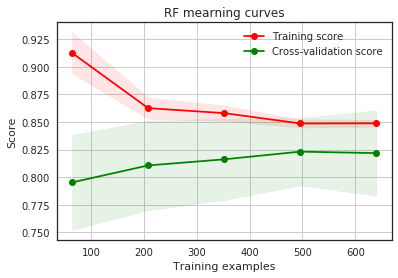

In [34]:
# RF Parameters tunning 
RFC = RandomForestClassifier()
## Search grid for optimal parameters
rf_param_grid = {
            "max_depth":[6,7,8,9],
            "max_leaf_nodes":[5,19,15,20,23,25,30],
            "min_samples_split":[2,5,8],
            "min_samples_leaf":[1,3,7,10],
              "n_estimators":[10,20,50]
}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold,n_jobs= -1, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_
print(RFC_best)
# Best score
print(gsRFC.best_score_)

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)

print('test score:',RFC_best.score(X_test,Y_test))

#### Adaboost

In [35]:
AdaBoostClassifier().get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.3min finished


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.05, n_estimators=400, random_state=6)
0.808988764045
test score: 0.826815642458


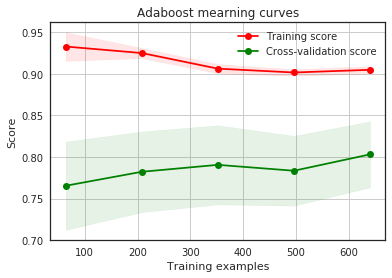

In [36]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=6)

ada_param_grid = {"base_estimator__criterion" : ["gini"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "learning_rate":  [0.001,0.005,0.01,0.05,0.1],
                 }

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, n_jobs= -1, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_;
print( ada_best)
print(gsadaDTC.best_score_)
g = plot_learning_curve(ada_best,"Adaboost mearning curves",X_train,Y_train,cv=kfold)

print('test score:',ada_best.score(X_test,Y_test))

#### Extra trees
RF的变种

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 1804 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3204 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5004 tasks      | elapsed:  3.1min


ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=5, max_features=7, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0.838483146067


[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:  3.7min finished


test score: 0.826815642458


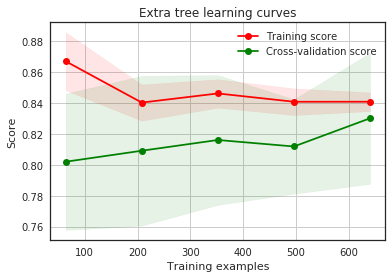

In [37]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [4,5,6],
              "max_features": [5, 7,10],
              "min_samples_split": [2,4],
              "min_samples_leaf": [2,3, 4,10],
              "bootstrap": [True,False],
              "n_estimators" :[10,50,80,100],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, n_jobs= -1, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_
print(ExtC_best)
# Best score
print(gsExtC.best_score_)

g = plot_learning_curve(ExtC_best,"Extra tree learning curves",X_train,Y_train,cv=kfold)

print('test score:',ExtC_best.score(X_test,Y_test))

#### GBDT 
梯度提升树

In [38]:
?GradientBoostingClassifier`

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 526 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 1026 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 1726 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  1.7min finished


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=15, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=30,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
0.835674157303
test score: 0.821229050279


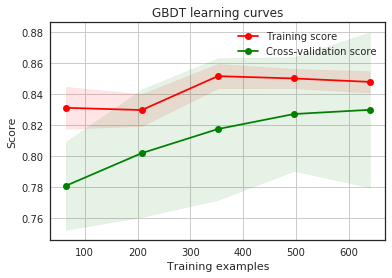

In [40]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [30,55,80],
              'learning_rate': [0.2,0.1,0.05,0.02,0.01],
              'max_depth': [4,6,8],
              'min_samples_leaf': [10,15,20,25],
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, n_jobs= -1, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

print(GBC_best)
print(gsGBC.best_score_)

g = plot_learning_curve(GBC_best,"GBDT learning curves",X_train,Y_train,cv=kfold)


print('test score:',GBC_best.score(X_test,Y_test));

#### SVC

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   41.2s finished


SVC(C=10, cache_size=200, class_weight=None, coef0=0.005,
  decision_function_shape='ovr', degree=3, gamma=0.02, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.837078651685
test score: 0.826815642458


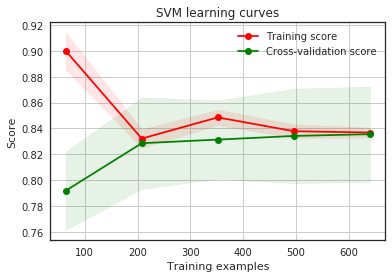

In [41]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf','poly'], 
                  'gamma': [ 0.001, 0.002 , 0.004, 0.01,0.02],
                  'coef0': [0.005, 0.01],
                  'C': [10,25,50,100]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, n_jobs= -1, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_
print(SVMC_best)
# Best score
print(gsSVMC.best_score_)

g = plot_learning_curve(SVMC_best,"SVM learning curves",X_train,Y_train,cv=kfold)
print('test score:',SVMC_best.score(X_test,Y_test))

#### LR

Fitting 10 folds for each of 252 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Done 308 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 2398 tasks      | elapsed:   35.4s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=7, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [10, 5, 2, 1, 0.5, 0.025, 0.01], 'tol': [0.01, 0.005, 0.001, 0.0001], 'max_iter': [100, 200, 400], 'solver': ['newton-cg', 'lbfgs', 'sag'], 'penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)
0.823033707865


[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed:   36.0s finished


test score: 0.826815642458


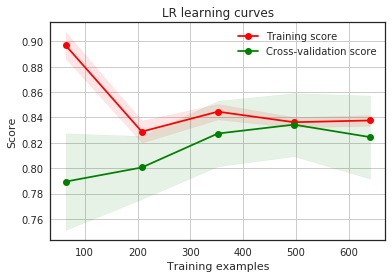

In [42]:
### Logistic cloassfier

# Adaboost
LR = LogisticRegression(random_state=7)

lr_param_grid = { 
              "C" : [10,5,2,1,0.5,0.025,0.01],
              "tol" :[0.01,0.005,0.001,0.0001],
              "max_iter":[100,200,400],
                "solver":['newton-cg', 'lbfgs','sag'],
                "penalty":['l2']
}

gsLR = GridSearchCV(LR,param_grid = lr_param_grid, cv=kfold , n_jobs= -1, verbose = 1);

gsLR.fit(X_train,Y_train);

print(gsLR)

LR_best = gsLR.best_estimator_

print(gsLR.best_score_)

g = plot_learning_curve(gsLR.best_estimator_,"LR learning curves",X_train,Y_train,cv=kfold)

print('test score:',LR_best.score(X_test,Y_test))

### Voting ensemble model
投票表决　哪个分类是最好的?

voting score on cv: [ 0.86111111  0.77777778  0.81944444  0.86111111  0.85915493  0.85915493
  0.83098592  0.8028169   0.81428571  0.8       ]
voting score mean: 0.828584283479
test score: 0.826815642458


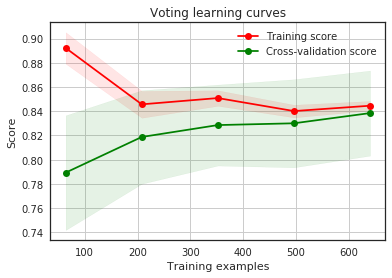

In [49]:

votingC = VotingClassifier(estimators=[
    ('rfc', RFC_best), 
    ('extc', ExtC_best),
    ('gbc',GBC_best),
    ('svm',SVMC_best),
], voting='soft', n_jobs=-1)

res=cross_val_score(votingC, X_train, y = Y_train, cv = kfold, n_jobs=-1)

print('voting score on cv:',res)
print('voting score mean:',res.mean())

# learning curves
g = plot_learning_curve(votingC,"Voting learning curves",X_train,Y_train,cv=kfold)

votingC.fit(X_train,Y_train);

print('test score:',votingC.score(X_test,Y_test))


### Predict all with best

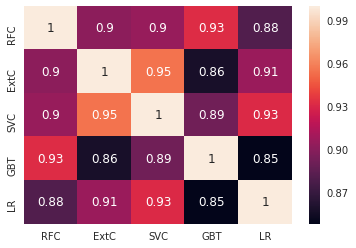

In [50]:
test_Survived_RFC = pd.Series(RFC_best.predict(test_valid), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test_valid), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test_valid), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test_valid), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test_valid), name="GBT")
test_Survived_LR = pd.Series(LR_best.predict(test_valid), name="LR")
test_Survived_XGB= pd.Series(RFC_best.predict(test_valid), name="XGB")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_SVMC,test_Survived_GBC,test_Survived_LR],axis=1)
g= sns.heatmap(ensemble_results.corr(),annot=True)



### Stacking ensemble model

选取若干独立的强分类器的结果，作为第2层stacking的输入。第2层的分类器，可以用xgboost.

注意layer 2的xgboost训练好后，其predict的test集，是也是layer 1的若干分类器predcit后的组合.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.5s finished


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
0.838483146067


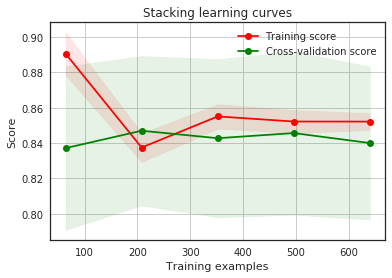

In [53]:
layer_1_X_train=pd.concat([
    pd.Series(RFC_best.predict(X_train),name="RFC"),
    pd.Series(ExtC_best.predict(X_train),name="ExtC"),
    pd.Series(SVMC_best.predict(X_train),name="SVC"),
    pd.Series(GBC_best.predict(X_train),name="GBT"),
    pd.Series(LR_best.predict(X_train),name="LR")
    ],axis=1)

#new kfold
kfold = StratifiedKFold(n_splits=10,shuffle=True);

StackingC = XGBClassifier()
## Search grid for optimal parameters
rf_param_grid = {
#               "gamma": [0.02,0.05,0.1,1],
#                 "subsample":[0.6,0.8,1],
#                  "colsample_bytree":[0.8,1],
#                 "n_estimators":[80],
#                 "learning_rate":[0.1,0.05,0.01],
#                 "subsample":[1,0.8,0.5]
                }

gsXGB = GridSearchCV(StackingC,param_grid = rf_param_grid, cv=kfold,n_jobs= -1, verbose = 1)
gsXGB.fit(layer_1_X_train,Y_train)

StackingC_best = gsXGB.best_estimator_

print(StackingC_best)
print(gsXGB.best_score_)
# learning curves
g = plot_learning_curve(StackingC_best,"Stacking learning curves",layer_1_X_train,Y_train,cv=kfold)

# predict
test_Survived_Stacking= pd.Series(StackingC_best.predict(ensemble_results), name="Stacking")

# print('test score:',StackingC_best.score(X_test,Y_test))

### Gen submission

In [56]:
# # GBDT
test_Survived_GBC = pd.Series(GBC_best.predict(test_valid))
results = pd.concat([IDtest,test_Survived_GBC.astype(int)],axis=1);
results.columns = ['PassengerId','Survived']
results.to_csv("titannic_GBDT.csv",index=False);
# SVM
test_Survived_SVMC = pd.Series(SVMC_best.predict(test_valid))
results = pd.concat([IDtest,test_Survived_SVMC.astype(int)],axis=1);
results.columns = ['PassengerId','Survived']
results.to_csv("titannic_SVM.csv",index=False);

# #RFC
results = pd.concat([IDtest,test_Survived_RFC.astype(int)],axis=1);
results.columns = ['PassengerId','Survived']
results.to_csv("titannic_RFC.csv",index=False);

# XGBOOST alone
results = pd.concat([IDtest,test_Survived_XGB.astype(int)],axis=1);
results.columns = ['PassengerId','Survived']
results.to_csv("titannic_XGB.csv",index=False);

# #EXT
results = pd.concat([IDtest,test_Survived_ExtC.astype(int)],axis=1);
results.columns = ['PassengerId','Survived']
results.to_csv("titannic_EXT.csv",index=False);

# # Voting
test_Survived_Voting = pd.Series(votingC.predict(test_valid))
results = pd.concat([IDtest,test_Survived_Voting.astype(int)],axis=1)
results.columns = ['PassengerId','Survived']
results.to_csv("titanic_ensemble_voting.csv",index=False)

# #Stacking
results = pd.concat([IDtest,test_Survived_Stacking.astype(int)],axis=1)
results.columns = ['PassengerId','Survived']
results.to_csv("titanic_ensemble_stacking.csv",index=False)